In [1]:
%matplotlib inline
import pandas as pd
import pprint
import subprocess
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from matplotlib import colors
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import FunctionTransformer, scale
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, classification_report, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from IPython.display import HTML, display

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(rc={'figure.figsize':(15,8)})  # Change all graphs backgrounds

In [3]:
white_wine_csv = "dataset/winequality-white.csv"

# Load The Data

We will be using pandas to load the data into a dataframe. On first inspection of the data, it was noticed that the csv file was using a different seperator than what one would normally see and when loading in the data from the csv file it was all coming out in one column. To get around this it was necessary to update the `sep` value to use `;` when using the `read_csv` function. 

The data is split into multiple columns. The dataset, which can be found here -  https://archive.ics.uci.edu/ml/datasets/wine+quality outlines the following features.

* 1 - fixed acidity 
* 2 - volatile acidity 
* 3 - citric acid 
* 4 - residual sugar 
* 5 - chlorides 
* 6 - free sulfur dioxide 
* 7 - total sulfur dioxide 
* 8 - density 
* 9 - pH 
* 10 - sulphates 
* 11 - alcohol 
* 12 - Output variable (based on sensory data): quality (score between 0 and 10)

In [4]:
df = pd.read_csv(white_wine_csv, header=None, sep=';', skiprows=1, names = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol", "quality"])

# Missing Data

Lets first scope out the data in the dataset to make sure there are no anomilies.

In [5]:
df.shape

(4898, 12)

Using the handy `shape` attribute of our dataframe we can quickly see that we are dealing with `4898` rows and `12` columns or features.

In [6]:
df.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

The `dtypes` attribute of the dataframe gives a quick summary of the data type of each column. The first 11 features have a data type of `float64` which is correct as we are dealing with decimal values. The 12th column is an `int64` data type. This is also correct as this value ranges from 0 - 10. The closer to 10 the higher the quality of wine. Based on the above output it looks like pandas is inferring the correct data types for each column

In [7]:
nans_predicate = df.isnull().any(axis=1)
nans = df[nans_predicate]
nans

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality


As all our data should be numeric and non null we can quickly check for the presence of non numeric or null data using the `nans_predicate` above. Luckily there are no null, or non numeric values detected which is good.

# Erroneous Data

Lets now do an analysis to see if we can find any erroneous data. What I will try to do in this section is determine if the data is reasonable from a logical sense.

In [8]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


The data above looks reasonable. All min and max values are within satisfactory bounds.

# Correlation

We can use heatmaps to get a visual representation of the correlation between features. If features are highly correlated we may be able to remove some features which will make processing much faster without degrading classification results.

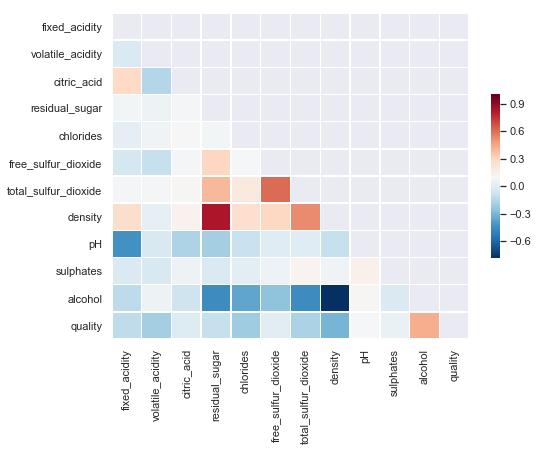

In [9]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, mask=mask, vmax=1, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, cmap="RdBu_r");

The first thing that imediatly pops out is that `density` and `residual sugar` appear to be very highly correlated. We can summarize the most correlated results using the function below.

In [10]:

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol", "quality"]], 20))

Top Absolute Correlations
residual_sugar        density                 0.838966
density               alcohol                 0.780138
free_sulfur_dioxide   total_sulfur_dioxide    0.615501
total_sulfur_dioxide  density                 0.529881
residual_sugar        alcohol                 0.450631
total_sulfur_dioxide  alcohol                 0.448892
alcohol               quality                 0.435575
fixed_acidity         pH                      0.425858
residual_sugar        total_sulfur_dioxide    0.401439
chlorides             alcohol                 0.360189
density               quality                 0.307123
residual_sugar        free_sulfur_dioxide     0.299098
free_sulfur_dioxide   density                 0.294210
fixed_acidity         citric_acid             0.289181
                      density                 0.265331
chlorides             density                 0.257211
free_sulfur_dioxide   alcohol                 0.250104
chlorides             quality          

The list above confirms our previous supicions of high correlation between `density` and `resuidual_sugar`. It may be possible to remove one of these features in the future if we need to tweak our results.

# Outliers

I will be using boxplots to try and detect any outliers within the dataset. First we can create a boxplot for the entire dataset features

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

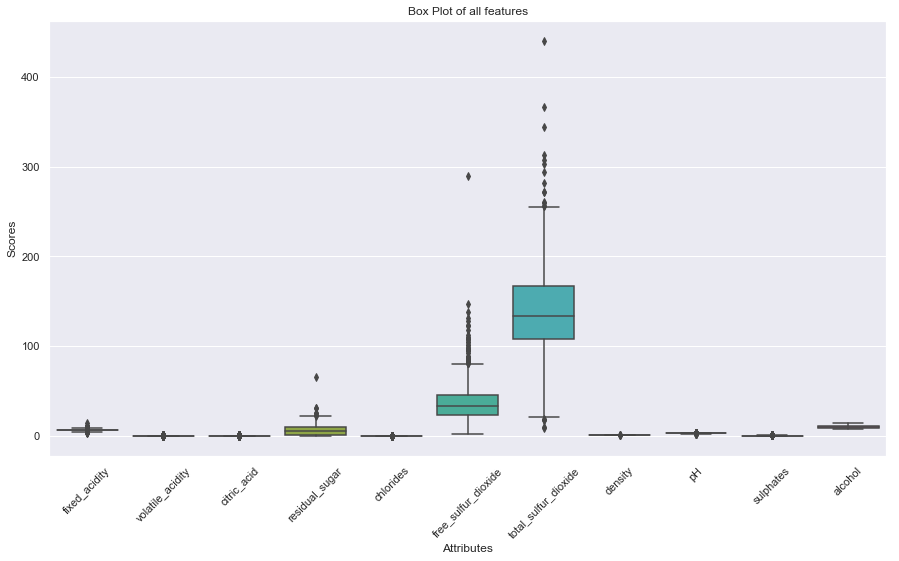

In [11]:
ax=sns.boxplot(data = df[["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"]])
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot of all features")
plt.setp(ax.get_xticklabels(), rotation=45)

It is clear that there is indeed a lot of outliers showing up on this boxplot. In particular it is apparent that the outliers are most abundant on these features

- total_sulfur_dioxide
- free_sulfur_dioxide
- residual_sugar

We can now create more refined boxplots for each of these features

[Text(0, 0.5, 'Scores'),
 Text(0.5, 0, 'total_sulfur_dioxide'),
 Text(0.5, 1.0, 'Box Plot for total sulfur dioxide')]

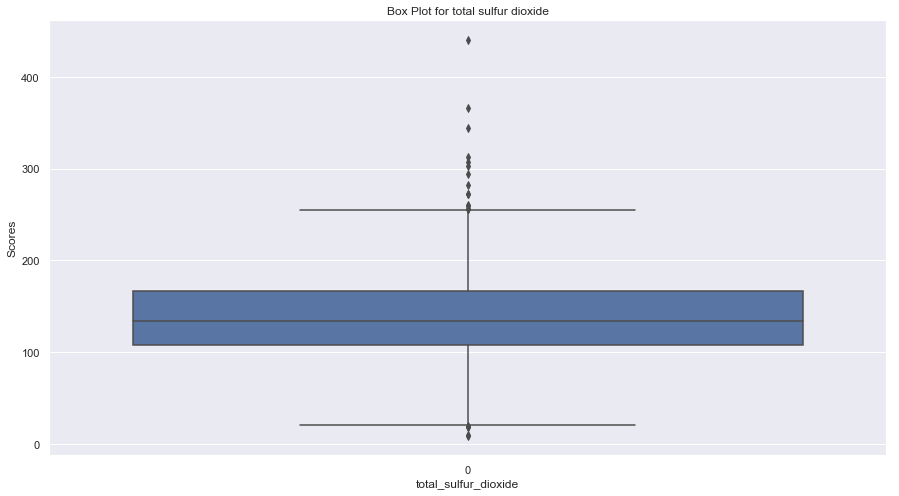

In [12]:
ax = sns.boxplot(data=df['total_sulfur_dioxide'])
ax.set(xlabel='total_sulfur_dioxide', ylabel='Scores', title="Box Plot for total sulfur dioxide")

The box plot for `total_sulfur_dioxide` indicates that there are a number of outliers.

[Text(0, 0.5, 'Scores'),
 Text(0.5, 0, 'free_sulfur_dioxide'),
 Text(0.5, 1.0, 'Box Plot for free sulfur dioxide')]

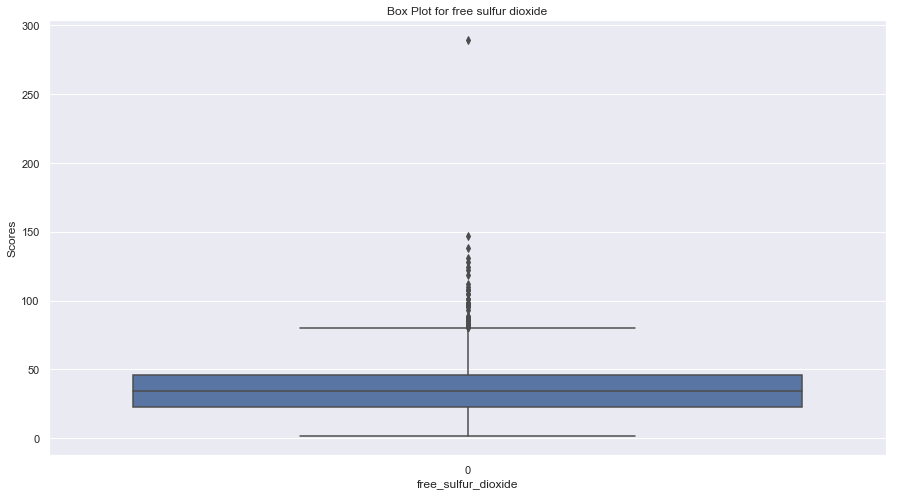

In [13]:
ax = sns.boxplot(data=df['free_sulfur_dioxide'])
ax.set(xlabel='free_sulfur_dioxide', ylabel='Scores', title="Box Plot for free sulfur dioxide")

Again, the box plot for `free_sulfur_dioxide` indicates that there are a number of outliers.

[Text(0, 0.5, 'Scores'),
 Text(0.5, 0, 'residual_sugar'),
 Text(0.5, 1.0, 'Box Plot for total residual sugar')]

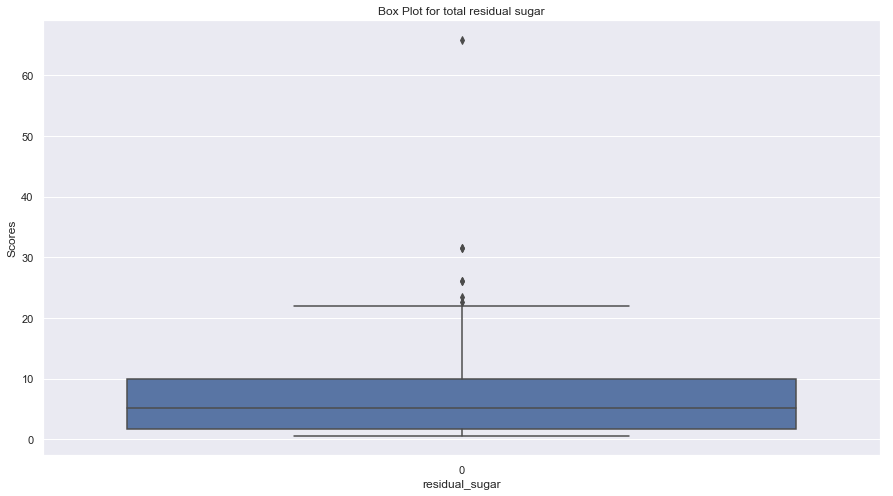

In [14]:
ax = sns.boxplot(data=df['residual_sugar'])
ax.set(xlabel='residual_sugar', ylabel='Scores', title="Box Plot for total residual sugar")

Again, the box plot for `residual_sugar` indicates that there are a number of outliers. We now have to decide what to do with these outliers. We have a few options here.

- We could completely drop the outliers from the dataset
- We could replace the outlier values with the mean value of the entire dataset feature

Below is a list summarizing the total outliers that we have detected

- 19 total_sulfur_dioxide
- 7 residual_sugar
- 45 free_sulfur_dioxide

As there are not a huge amount of outliers we can elect to drop these datapoints from the dataset.

In [15]:
def dropOutliers(feature):
    feat = df[feature]

    q1 = feat.quantile(0.25)
    q3 = feat.quantile(0.75)
    iqr = q3 - q1
    lw = q1 - 1.5 * iqr
    uw = q3 + 1.5 * iqr
    
    outlier_predicate = (df[feature] > uw) | (df[feature] < lw)
    
    print("Lower:", lw)
    print("Upper:", uw)
    print("Total outliers:", df[outlier_predicate].count()[feature])
    
    df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows


dropOutliers('total_sulfur_dioxide')

Lower: 19.5
Upper: 255.5
Total outliers: 19


In [16]:
dropOutliers('residual_sugar')

Lower: -10.600000000000001
Upper: 22.200000000000003
Total outliers: 7


In [17]:
dropOutliers('free_sulfur_dioxide')

Lower: -11.5
Upper: 80.5
Total outliers: 45


In [18]:
df.shape

(4827, 12)

Now that we have dropped all the outliers we can again view a boxplot of the entire dataset

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

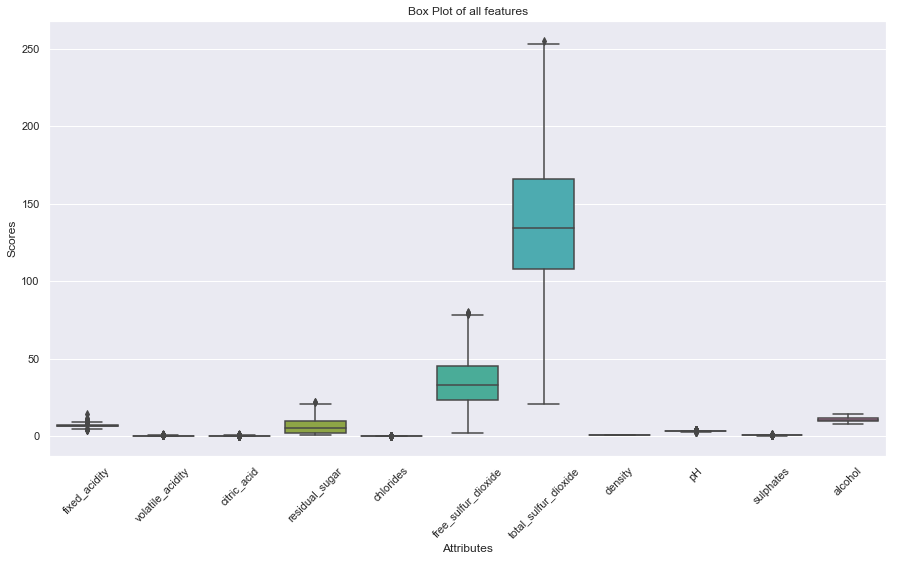

In [19]:
ax=sns.boxplot(data = df[["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"]])
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot of all features")
plt.setp(ax.get_xticklabels(), rotation=45)

# Classification

### Logistic Regression Model

We will first be using the logistic regression model to try and get an accuacy score for our classifier.

In [20]:
X = df.drop(['quality'], axis='columns')  # X = features
y = df['quality']                       # y = prediction target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)

lr_acc_score = accuracy_score(y_test, lr_predict)

# Variable to hold result for summary
logistic_regression_before_features = lr_acc_score*100

print(lr_acc_score*100)

52.52692626346314


The total score is around 51%. Realistically this is a pretty poor score. Lets see if Descision Tree Classification performs any better

### Decision Tree Classification

In [21]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
dt_predict = dt.predict(x_test)

dt_acc_score = accuracy_score(y_test, dt_predict)

# Variable to hold result for summary
decision_tree_before_features = dt_acc_score*100

print(dt_acc_score*100)

59.486329743164866


The Decision Tree Classification did indeed perform better at around 57% accuracy. However this still is not a satisfactory score. Lets now try and tweak our features to see if we can make the classification perform better.

### Random Forrest Classification

In [22]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_predict=rf.predict(x_test)

rf_acc_score = accuracy_score(y_test, rf_predict)

# Variable to hold result for summary
random_forest_before_features = rf_acc_score*100

print(rf_acc_score*100)

63.96023198011599


For decision tree classification the result is around 66%. This has performed reasonably well. But again it is not quite satisfactory

# New Features

In this section I will try 2 things.

- Drop one of the previous highly correlated features.
- Add a new feature called "score" which will better summarize the quality. 

One of the issues with the classification before is that it was trying to match an exact number between 0 and 10. It might be better if we broke down the quality feature further into a new feature. This feature will hold a value between 0 and 3.

- 0 indicated poor quality wine
- 1 indicated average quality wine
- 2 indicated high quality wine

We can say that a poor quality wine could be a value between 0 and 3. An average quality wine would be a value between 4 and 7. And a high quality wine would be a value between 8 and 10

First lets drop one of the highly correlated features. In this case we will chose `residual_sugar`

In [23]:
df_no_residual_sugar = df.drop(['residual_sugar'], axis='columns')

df_no_residual_sugar.head()

,fixed_acidity,volatile_acidity,citric_acid,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


The `residual_sugar` feature has now been dropped and we created a new dataframe to hold the new dataset called `df_no_residual_sugar`

Next lets create a new feature for the `score`

In [24]:
df_score = df_no_residual_sugar.copy()
 
df_score['score'] = df_score.apply(lambda row: 0 if row['quality'] <= 3 else 1 if row['quality'] > 3 and row['quality'] <= 7 else 2, axis=1)

df_score = df_score.drop(['quality'], axis='columns')

df_score.head()

,fixed_acidity,volatile_acidity,citric_acid,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,score
0,7.0,0.27,0.36,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [25]:
print(df_score.loc[df_score['score'] == 0].shape)
print(df_score.loc[df_score['score'] == 1].shape)
print(df_score.loc[df_score['score'] == 2].shape)

(14, 11)
(4638, 11)
(175, 11)


To summarize, we have

- 14 low quality wines
- 4638 Average wines
- 175 High quality wines

We can now run our prediction classifiers again using

- Logistic Regression
- Decision Tree Classification

In [26]:
X = df_score.drop('score', axis='columns')  # X = features
y = df_score['score']                       # y = prediction target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

We will use 25% of the entire dataset to train our model

In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3620, 10)
(3620,)
(1207, 10)
(1207,)


### Logistic Regression

In [28]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)

lr_acc_score = accuracy_score(y_test, lr_predict)

# Variable to hold result for summary
logistic_regression_after_features = lr_acc_score*100

print(lr_acc_score*100)

95.85749792874897


We now are getting an accuracy of 96%. This is a huge increase in accuracy and is very satisfactory. Lets see how the Decision tree classifier worked out

### Decision Tree Classifier

In [29]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
dt_predict = dt.predict(x_test)

dt_acc_score = accuracy_score(y_test, dt_predict)

# Variable to hold result for summaryx_train
decision_tree_after_features = dt_acc_score*100

print(dt_acc_score*100)

95.11184755592377


Interestingly this is now showing a lower result than logistic regression. But at 94% it is still satisfactory. Finally lets try the Random Forrest Classifier

### Random Forest Classifier

In [30]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_predict=rf.predict(x_test)

rf_acc_score = accuracy_score(y_test, rf_predict)

# Variable to hold result for summary
random_forest_after_features = rf_acc_score*100

print(rf_acc_score*100)

96.93454846727423


97% is a fantastic result. This appears to be the highest so far. We can now move onto trying to optimize our hyper parameters.

# Hyper-perameter Optimization

### Logistic Regression

In [31]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Above is a list of all the possible hyper parameters for the LogisticRegression. More info can be found here https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [32]:
random_dt_grid = {
    'C': np.arange(1, 100),
    'penalty': ['l1', 'l2'],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'warm_start': [True, False],
    'random_state': np.arange(1, 20)
}

dtr = LogisticRegression()
grid_search = RandomizedSearchCV(estimator = dtr, param_distributions = random_dt_grid, n_iter = 100, cv = 5, n_jobs = -1)
grid_search.fit(x_train, y_train)

# Variable to hold result for summary
logistic_regression_after_opt = grid_search.best_score_ * 100

pp = pprint.PrettyPrinter(indent=4)
pp.pprint({'Best params': grid_search.best_params_, 
           'Best score': grid_search.best_score_ * 100, 
           'Best estimator': grid_search.best_estimator_})

{   'Best estimator': LogisticRegression(C=35, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=8, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
    'Best params': {   'C': 35,
                       'class_weight': None,
                       'fit_intercept': False,
                       'penalty': 'l2',
                       'random_state': 8,
                       'warm_start': False},
    'Best score': 96.16022099447514}


### Decision Tree Classifier

In [33]:
DecisionTreeClassifier().get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

Above is a list of all the possible hyper parameters for the DecisionTreeClassifier. More info can be found here https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [34]:
random_dt_grid = {
    'criterion':['entropy', 'gini'],
    'max_depth': np.arange(1, 1000),
    'class_weight': [None, 'balanced'],
    'min_samples_leaf': np.arange(1, 100),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

dtr = DecisionTreeClassifier()
grid_search = RandomizedSearchCV(estimator = dtr, param_distributions = random_dt_grid, n_iter = 100, cv = 5, random_state=42, n_jobs = -1)
grid_search.fit(x_train, y_train)

# Variable to hold result for summary
decision_tree_after_opt = grid_search.best_score_ * 100

pp = pprint.PrettyPrinter(indent=4)
pp.pprint({'Best params': grid_search.best_params_, 
           'Best score': grid_search.best_score_ * 100, 
           'Best estimator': grid_search.best_estimator_})

{   'Best estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=308,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=90, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
    'Best params': {   'class_weight': None,
                       'criterion': 'entropy',
                       'max_depth': 308,
                       'max_features': None,
                       'min_samples_leaf': 90},
    'Best score': 96.16022099447514}


### Random Forest Classifier

In [35]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Above is a list of all the possible hyper parameters for the DecisionTreeClassifier. More info can be found here https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [36]:
random_dt_grid = {
    'criterion':['entropy', 'gini'],
    'max_depth': np.arange(1000),
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'min_samples_leaf': np.arange(1, 5),
    'min_samples_split': np.arange(2, 5),
    'warm_start': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

dtr = RandomForestClassifier()
grid_search = RandomizedSearchCV(estimator = dtr, param_distributions = random_dt_grid, n_iter = 100, cv = 5, random_state=42, n_jobs = -1)
grid_search.fit(x_train, y_train)

# Variable to hold result for summary
random_forest_after_opt = grid_search.best_score_ * 100

pp = pprint.PrettyPrinter(indent=4)
pp.pprint({'Best params': grid_search.best_params_, 
           'Best score': grid_search.best_score_ * 100, 
           'Best estimator': grid_search.best_estimator_})

{   'Best estimator': RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=822, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=True),
    'Best params': {   'class_weight': 'balanced',
                       'criterion': 'entropy',
                       'max_depth': 822,
                       'max_features': 'sqrt',
                       'min_samples_leaf': 1,
                       'min_samples_split': 2,
                       'warm_start': True},
    'Best score': 97.29281767955801}


# Summary

Below is a summary of the results

In [37]:
data = [
    ['Logistic Regression', "%.2f" % logistic_regression_before_features, "%.2f" % logistic_regression_after_features,"%.2f" % logistic_regression_after_opt],
    ['Decision Tree', "%.2f" % decision_tree_before_features, "%.2f" % decision_tree_after_features, "%.2f" % decision_tree_after_opt],
    ['Random Forrest', "%.2f" % random_forest_before_features, "%.2f" % random_forest_after_features, "%.2f" % random_forest_after_opt],
]

display(HTML(
    '<table><thead><tr><th>Classifier</th><th>Before New Features</th><th>After New Features</th><th>Hyper Parameter Optimization</th></tr></thead><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
))


Classifier,Before New Features,After New Features,Hyper Parameter Optimization
Logistic Regression,52.53,95.86,96.16
Decision Tree,59.49,95.11,96.16
Random Forrest,63.96,96.93,97.29
